In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir('..')

In [2]:
from liver_microsome_prediction.utils import *
from liver_microsome_prediction.processing import *

In [3]:
os.environ['DGLBACKEND'] = "pytorch"
import dgl
from dgl.data import DGLDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import deepchem as dc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [4]:
def set_random_seed_torch(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_random_seed_torch(SEED)

In [5]:
train_data = pd.read_csv(PATH.train)
test_data  = pd.read_csv(PATH.test)
targets    = ['MLM', 'HLM']
test_data[targets] = -1

In [6]:
train_data.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.01,50.68,3.26,400.50,5,2,8,3.26,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.27,50.59,2.17,301.41,2,1,2,2.17,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.59,80.89,1.59,297.36,5,0,3,1.58,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC5)CC4)c3C)nn2)cc1,5.71,2.00,4.77,494.65,6,0,5,3.48,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.27,99.99,2.33,268.31,3,0,1,2.34,42.43


In [7]:
test_data.head()

,id,SMILES,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,MLM,HLM
0,TEST_000,CC(C)Nc1ccnc(N2CCN(Cc3cccs3)C(CCO)C2)n1,2.64,361.50,4,2,7,2.63,92.76,-1,-1
1,TEST_001,COc1cc(=O)n(-c2ccccc2)cc1C(=O)N1CCC2(CC1)OCCO2,0.58,370.40,5,0,3,0.58,68.31,-1,-1
2,TEST_002,Cc1cccc(NC(=N)/N=c2\nc(O)c(Cc3ccccc3)c(C)[nH]2)c1,4.28,347.41,4,4,5,4.29,92.86,-1,-1
3,TEST_003,O=C(c1nc2ncccn2n1)N1CCCn2cc(-c3ccccc3)nc21,1.79,345.36,5,0,2,1.79,81.21,-1,-1
4,TEST_004,CCN1CCN(C(=O)c2cc3c(=O)n4cc(C)ccc4nc3n2C)CC1,1.22,353.42,4,0,2,0.17,61.15,-1,-1


In [8]:
PARAMS = dict(
    batch_size=128,
    batch_size_ssl=1024,
    n_epochs=1000,
#     n_atoms=9,
    n_atoms=6,
    n_targets=2,
    n_features=30,
    n_node_features=30,
    hidden_channels=64,
    pred_channels=64
)

In [9]:
# from sklearn.impute import SimpleImputer

# imputer = SimpleImputer()
# impute_cols = ['AlogP']
# train_data[impute_cols] = imputer.fit_transform(train_data[impute_cols])
# test_data[impute_cols]  = imputer.transform(test_data[impute_cols])

In [10]:
# pd.DataFrame([raw_open_data[idx].split('\t')[1] for idx in idxs], columns=['smiles'])

In [11]:
# with open(PATH.open, 'r') as smiles:
#     raw_open_data = smiles.read()
# raw_open_data = raw_open_data.split('\n')

# open_smiles = np.array([smiles.split('\t')[1] for smiles in raw_open_data if '\t' in smiles])
# len(open_smiles)

In [12]:
# _, axes = plt.subplots(1, 2, figsize=(10, 1))
# open_data.smiles.str.len().plot.hist(bins=50, ax=axes[0]), train_data.SMILES.str.len().plot.hist(bins=50, ax=axes[1]);

In [13]:
# train_data.SMILES.str.len().max()

In [14]:
# open_data = open_data[open_data.smiles.str.len() <= train_data.SMILES.str.len().max()]

In [15]:
# _, axes = plt.subplots(1, 2, figsize=(10, 1))
# open_data.smiles.str.len().plot.hist(bins=50, ax=axes[0]), train_data.SMILES.str.len().plot.hist(bins=50, ax=axes[1]);

In [16]:
n_open_data = 10_000

open_data_smiles = []
with open(PATH.open, 'r') as f:
    while len(open_data_smiles) < n_open_data:
        line = next(f).strip()
        if '\t' not in line:
            continue
        smiles = line.split('\t')[1]
        if len(smiles) > 174:
            continue
        open_data_smiles.append(smiles)

open_data = pd.DataFrame(open_data_smiles, columns=['SMILES'])
open_data[targets] = -1
open_data

,SMILES,MLM,HLM
0,CC(=O)OC(CC(=O)[O-])C[N+](C)(C)C,-1,-1
1,CC(=O)OC(CC(=O)O)C[N+](C)(C)C,-1,-1
2,C1=CC(C(C(=C1)C(=O)O)O)O,-1,-1
3,CC(CN)O,-1,-1
4,C(C(=O)COP(=O)(O)O)N,-1,-1
...,...,...,...
9995,C1CCN(C1)CCN2C3=CC=CC=C3SC4=CC=CC=C42,-1,-1
9996,C1CC(C2=CC=CC=C2C1)C3=NCCN3.Cl,-1,-1
9997,CC1=[N+](C2=CC=CC=C2C(=C1)N)CCCCCCCCCC[N+]3=C(C=C(C4=CC=CC=C43)N)C.[Cl-].[Cl-],-1,-1
9998,CCCCCC(=O)CC1=C2C(=CC(=C1)OC)OC3=C(C=C(C(=C3CC(=O)CCCCC)C(=O)O)O)OC2=O,-1,-1


In [17]:
train_data[targets].describe()

,MLM,HLM
count,3498.00,3498.00
mean,37.38,53.09
std,35.70,36.08
min,0.00,0.00
25%,2.43,15.91
50%,26.19,58.02
75%,70.81,87.75
max,131.72,135.34


In [18]:
from torch_geometric.data import DataLoader, InMemoryDataset
from sklearn.preprocessing import MinMaxScaler


y_scaler = MinMaxScaler()

class MoleculeDataset(InMemoryDataset):
    def __init__(self, root, data_id, targets, task_id):
        self.root       = root
        self.data_id    = data_id
        self.targets    = targets
        self.task_id    = task_id
        self.featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        
        super().__init__(root, None, None)
        self.data, self.slices = torch.load(self.processed_paths[0])
        
    @property
    def raw_file_names(self):
        if self.data_id == 'open':
            return ['CID-SMILES']
        else:
            return [f"{basename(self.data_id)}.csv"]
    
    @property
    def processed_file_names(self):
        return [f"{self.task_id}/{basename(self.data_id)}.pt"]


class AtomClassificationMoleculeDataset(MoleculeDataset):
    def __init__(self, root, data_id, targets, n_open_data=None):
        self.n_open_data = n_open_data
        super().__init__(root, data_id, targets, task_id='atom_classification')

    def process(self):
        if self.data_id in ('train', 'test'):
            self.data = pd.read_csv(self.raw_paths[0])
            graphs = self.featurizer.featurize(self.data.SMILES)
        else:
            assert self.n_open_data > 0, "n_open_data should be set for 'open' dataset"
            graphs = []
            with open(self.raw_paths[0], 'r') as f:
                while len(graphs) < self.n_open_data:
                    print("- Current len(graphs):", len(graphs))
                    line = next(f).strip()
                    if '\t' not in line:
                        continue
                    smiles = line.split('\t')[1]
                    if len(smiles) > 174:
                        continue
                    try:
                        g = self.featurizer.featurize(smiles)[0]
                        if g.num_nodes > 0:
                            graphs.append(g)
                    except:
                        continue
        
        data_list = []
        for idx, g_dc in enumerate(graphs):
            g_dgl = g_dc.to_dgl_graph()
#             g_dgl = dgl.add_self_loop(g_dgl)  # add_self_loop is default in `nn.conv.GCNConv(add_self_loops=True)`
            g_pyg   = from_dgl(g_dgl)
            g_pyg   = self.mask_nodes(g_pyg)
            g_pyg.y = g_pyg.x[:, :PARAMS['n_atoms']].argmax(dim=1)
            g_pyg   = g_pyg.to(device)
            data_list.append(g_pyg)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])
    
    def mask_nodes(self, g):
        n_nodes    = g.num_nodes
        masked_idx = np.random.choice(n_nodes, n_nodes//2, replace=False)
        g.masked_idx    = torch.IntTensor(masked_idx)
        g.x[masked_idx] = 0
        return g


class MoleculeRegressionMoleculeDataset(MoleculeDataset):
    def __init__(self, root, data_id, targets):
        super().__init__(root, data_id, targets, task_id='molecule_regression')
        
    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        if self.data_id == 'test':
            self.data[targets] = -1
        
        data_list = []
        graphs = self.featurizer.featurize(self.data.SMILES)
        for idx, (g_dc, y) in enumerate(zip(graphs, self.data[targets].values)):
            g_dgl = g_dc.to_dgl_graph()
#             g_dgl = dgl.add_self_loop(g_dgl)  # add_self_loop is default in `nn.conv.GCNConv(add_self_loops=True)`
            g_pyg = from_dgl(g_dgl)
#             g_pyg = self.mask_nodes(g_pyg)
            g_pyg.y = torch.FloatTensor(y) / 140
            g_pyg = g_pyg.to(device)
            data_list.append(g_pyg)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [19]:
ds_open     = AtomClassificationMoleculeDataset(root=PATH.data, data_id='open', targets=targets, n_open_data=100_000)
n_test_data = len(ds_open)//5

ds_train = ds_open[:-2*n_test_data]
ds_val   = ds_open[-2*n_test_data:-n_test_data]
ds_test  = ds_open[-n_test_data:]

dataloaders = dict(
    atom_classification=dict(
        train=DataLoader(ds_train, PARAMS['batch_size'],     shuffle=True),
        val=DataLoader(ds_val,     PARAMS['batch_size_ssl'], shuffle=False),
        test=DataLoader(ds_test,   1,                        shuffle=False)
    )
)

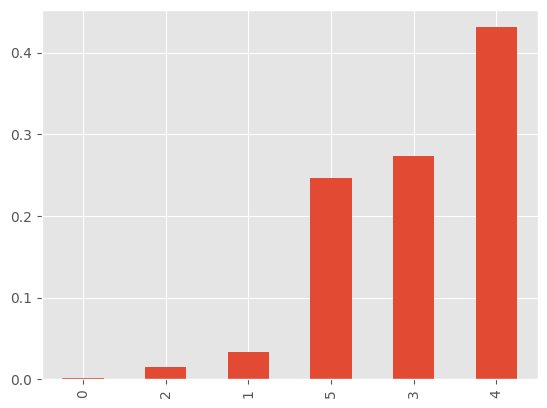

In [20]:
atoms = ds_open.x[:, :PARAMS['n_atoms']]
weights = 1/pd.Series(atoms.argmax(1).cpu().detach().numpy()).value_counts()
weights /= sum(weights)
weights.plot.bar();

weights = torch.FloatTensor(weights).to(device)
weights = weights[:6]
weights /= weights.sum()

In [21]:
ds_train_val = MoleculeRegressionMoleculeDataset(root=PATH.data, data_id='train', targets=targets)
n_val_data   = len(ds_train_val)//5

ds_train = ds_train_val[:-n_val_data]
ds_val   = ds_train_val[-n_val_data:]
ds_test  = MoleculeRegressionMoleculeDataset(root=PATH.data, data_id='test', targets=targets)

dataloaders.update(dict(
    molecule_regression=dict(
        train=DataLoader(ds_train, PARAMS['batch_size'], shuffle=True),
        val=DataLoader(ds_val,     PARAMS['batch_size'], shuffle=False),
        test=DataLoader(ds_test,   1,                    shuffle=False)
    )
))

In [25]:
from torch_geometric.nn import GCNConv, aggr


class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels_ssl, out_channels_sl, pred_channels):
        super().__init__()
        self.in_channels     = in_channels
        self.hidden_channels = hidden_channels
        self.conv1   = GCNConv(in_channels, hidden_channels)
        self.conv2   = GCNConv(hidden_channels, hidden_channels)
        self.out_ssl = Predictor(hidden_channels, out_channels_ssl)
        self.readout = aggr.SumAggregation()
#         self.readout = ReadOut(hidden_channels, pred_channels, act=nn.ReLU())
        self.pred1   = Predictor(pred_channels, pred_channels, act=nn.ReLU())
        self.pred2   = Predictor(pred_channels, pred_channels, act=nn.Tanh())
        self.out_sl  = Predictor(pred_channels, out_channels_sl)
                
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # x: Node feature matrix of shape [num_nodes, in_channels]
        # edge_index: Graph connectivity matrix of shape [2, num_edges]
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        y_ssl = self.out_ssl(x)
        
#         x = x.view(-1, self.in_channels, self.hidden_channels)
#         x = self.readout(x)
        x = self.readout(x, ptr=data.ptr)
        x = self.pred1(x)
        x = F.dropout(x, training=self.training)
        x = self.pred2(x)
        x = F.dropout(x, training=self.training)
        y_sl = self.out_sl(x)
        
        return y_ssl, y_sl


class ReadOut(nn.Module):
    def __init__(self, in_dim, out_dim, act=None):
        super().__init__()
        
        self.in_dim  = in_dim
        self.out_dim = out_dim
        self.linear  = nn.Linear(self.in_dim, self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out
    
class Predictor(nn.Module):
    def __init__(self, in_dim, out_dim, act=None):
        super().__init__()
        self.in_dim  = in_dim
        self.out_dim = out_dim
        self.linear  = nn.Linear(self.in_dim, self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [26]:
model = GCN(PARAMS['n_node_features'], PARAMS['hidden_channels'],
            out_channels_ssl=PARAMS['n_atoms'], out_channels_sl=PARAMS['n_targets'], pred_channels=PARAMS['hidden_channels']).to(device)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model

GCN(
  (conv1): GCNConv(30, 64)
  (conv2): GCNConv(64, 64)
  (out_ssl): Predictor(
    (linear): Linear(in_features=64, out_features=6, bias=True)
  )
  (readout): SumAggregation()
  (pred1): Predictor(
    (linear): Linear(in_features=64, out_features=64, bias=True)
    (activation): ReLU()
  )
  (pred2): Predictor(
    (linear): Linear(in_features=64, out_features=64, bias=True)
    (activation): Tanh()
  )
  (out_sl): Predictor(
    (linear): Linear(in_features=64, out_features=2, bias=True)
  )
)

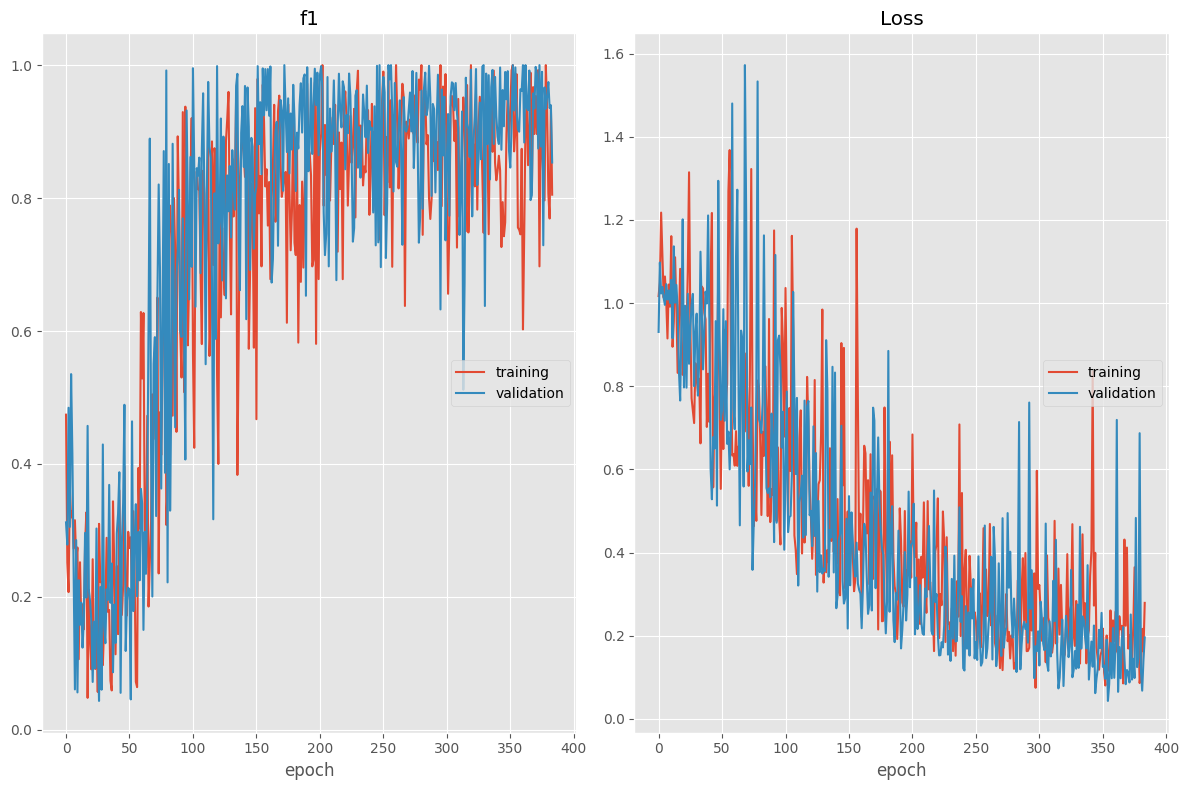

f1
	training         	 (min:    0.048, max:    1.000, cur:    0.805)
	validation       	 (min:    0.043, max:    1.000, cur:    0.853)
Loss
	training         	 (min:    0.075, max:    1.368, cur:    0.279)
	validation       	 (min:    0.043, max:    1.572, cur:    0.196)


KeyboardInterrupt: 

In [187]:
from livelossplot import PlotLosses
import torchmetrics as tm

# get_acc = tm.Accuracy(task='multiclass', num_classes=PARAMS['n_atoms']).to(device)
get_acc = tm.F1Score(task='multiclass', num_classes=PARAMS['n_atoms']).to(device)


def train_step(batch):
    y_logit, _     = model(batch)
    y_logit_masked = y_logit[batch.masked_idx]
    y_true_masked  = batch.y[batch.masked_idx]
    loss = F.cross_entropy(y_logit_masked, y_true_masked, weight=weights)
    acc  = get_acc(y_logit_masked.argmax(1), y_true_masked)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, acc
    
def val_step(batch):
    y_logit, _     = model(batch)
    y_logit_masked = y_logit[batch.masked_idx]
    y_true_masked  = batch.y[batch.masked_idx]
    loss = F.cross_entropy(y_logit_masked, y_true_masked, weight=weights)
    acc  = get_acc(y_logit_masked.argmax(1), y_true_masked)
    return loss, acc


liveloss  = PlotLosses()
# rst       = pd.DataFrame(columns=['loss', 'acc', 'val_loss', 'val_acc'], index=pd.Index([], name='Epoch'))
rst       = pd.DataFrame(columns=['loss', 'f1', 'val_loss', 'val_f1'], index=pd.Index([], name='Epoch'))
for epoch in range(1, PARAMS['n_epochs']):
    for batch in dataloaders['atom_classification']['train']:
        loss, acc = train_step(batch)
        
    with torch.no_grad():
        for batch in dataloaders['atom_classification']['val']:
            val_loss, val_acc = val_step(batch)
    
    rst.loc[epoch] = lmap(float, (loss, acc, val_loss, val_acc))
    record = rst.loc[epoch]
    min_val_loss = min(rst.val_loss)
    if (epoch == 1) or (rst.loc[epoch, 'val_loss'] == min_val_loss):
#         ckpt_path = join(PATH.ckpt, f"GCN_SSL-loss_{record.loss:.4}-acc_{record.acc:.4}-val_loss_{record.val_loss:.4}-val_acc_{record.val_acc:.4}.pt")
        ckpt_path = join(PATH.ckpt, f"GCN_SSL-loss_{record.loss:.4}-acc_{record.f1:.4}-val_loss_{record.val_loss:.4}-val_f1_{record.val_f1:.4}.pt")
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'loss': record.loss, 'val_loss': record.val_loss}, ckpt_path)
    
    liveloss.update(rst.loc[epoch])
    liveloss.send()

---

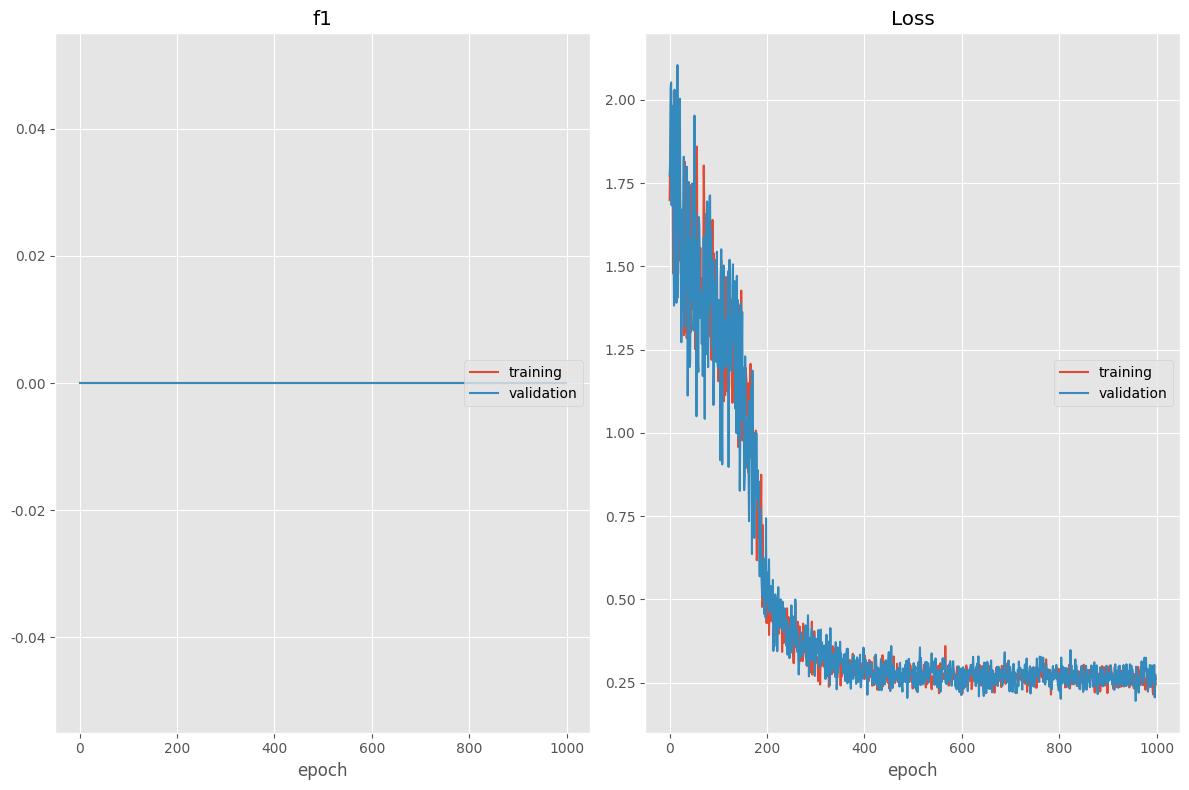

f1
	training         	 (min:    0.000, max:    0.000, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Loss
	training         	 (min:    0.215, max:    2.028, cur:    0.245)
	validation       	 (min:    0.195, max:    2.105, cur:    0.261)


In [29]:
from livelossplot import PlotLosses
import torchmetrics as tm


def train_step(batch):
    _, y_sl = model(batch)
    batch.y = batch.y.view(-1, 2)
    loss = torch.sqrt(F.mse_loss(y_sl, batch.y))
    acc  = 0  # get_acc(y_sl, batch.y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, acc
    
def val_step(batch):
    _, y_sl = model(batch)
    batch.y = batch.y.view(-1, 2)
    loss = torch.sqrt(F.mse_loss(y_sl, batch.y))
    acc  = 0  # get_acc(y_sl, batch.y)
    return loss, acc


liveloss  = PlotLosses()
rst       = pd.DataFrame(columns=['loss', 'f1', 'val_loss', 'val_f1'], index=pd.Index([], name='Epoch'))
for epoch in range(1, PARAMS['n_epochs']):
    for batch in dataloaders['molecule_regression']['train']:
        loss, acc = train_step(batch)
        
    with torch.no_grad():
        for batch in dataloaders['molecule_regression']['val']:
            val_loss, val_acc = val_step(batch)
    
    rst.loc[epoch] = lmap(float, (loss, acc, val_loss, val_acc))
    record = rst.loc[epoch]
    min_val_loss = min(rst.val_loss)
    if (epoch == 1) or (rst.loc[epoch, 'val_loss'] == min_val_loss):
#         ckpt_path = join(PATH.ckpt, f"GCN_SSL-loss_{record.loss:.4}-acc_{record.acc:.4}-val_loss_{record.val_loss:.4}-val_acc_{record.val_acc:.4}.pt")
        ckpt_path = join(PATH.ckpt, f"GCN_SL-loss_{record.loss:.4}-acc_{record.f1:.4}-val_loss_{record.val_loss:.4}-val_f1_{record.val_f1:.4}.pt")
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'loss': record.loss, 'val_loss': record.val_loss}, ckpt_path)
    
    liveloss.update(rst.loc[epoch])
    liveloss.send()

In [30]:
sample = pd.read_csv(PATH.sample)

preds = []
with torch.no_grad():
    for batch in dataloaders['molecule_regression']['test']:
        _, y_sl = model(batch)
        preds.append(y_sl.detach().cpu().numpy()[0])
preds = np.array(preds)

In [32]:
sample[targets] = preds
sample

,id,MLM,HLM
0,TEST_000,0.21,0.36
1,TEST_001,0.27,0.38
2,TEST_002,0.24,0.35
3,TEST_003,0.31,0.42
4,TEST_004,0.26,0.34
5,TEST_005,0.18,0.36
6,TEST_006,0.30,0.35
7,TEST_007,0.27,0.45
8,TEST_008,0.25,0.35
9,TEST_009,0.36,0.46


In [33]:
sample[targets] *= 140

In [34]:
sample

,id,MLM,HLM
0,TEST_000,28.75,50.35
1,TEST_001,38.28,52.61
2,TEST_002,33.36,48.55
3,TEST_003,43.72,58.97
4,TEST_004,37.00,47.88
5,TEST_005,25.11,49.99
6,TEST_006,41.38,49.15
7,TEST_007,38.02,63.58
8,TEST_008,35.45,49.09
9,TEST_009,49.72,63.73


In [35]:
sample.to_csv(join(PATH.out, "3_semi-supervised-learning-GCN-without-pretraining.csv"), index=False)